In [ ]:
%reload_ext autoreload
%autoreload 2


In [104]:
import matplotlib.pyplot as plt
import numpy as np
from cereeberus import Interleave, MapperGraph
from sklearn.cluster import DBSCAN
from sklearn import datasets
from sklearn.manifold import MDS
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import letters  # this generates letter data. Right now I am generating letters
import process_letters as pl # this creates the mapper graph from the letter data
import matplotlib.patches as mpatches
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import itertools
from multiprocessing import Pool, cpu_count
import letters
from tqdm import tqdm
import pandas as pd


## Create the Mappers from the letter data 

In [ ]:
letter_data = letters.gen_letters()


In [ ]:
keys = list(letter_data.keys())

# Create mappers for all letters
mappers = {}
for key in keys:
    mappers[key] = []
    for sample in letter_data[key]:
        mapper = pl.generate_mapper(sample)
        mappers[key].append(mapper)


## Workflow

In [ ]:


def get_input_data():
    letter_data = letters.gen_letters() # these are point clouds
      
    mappers = {}
    for key, samples in letter_data.items():
        mappers[key] = [pl.generate_mapper(sample) for sample in samples]
    return mappers

def pairwise_comparison(args):
    letter1, idx1, letter2, idx2, mappers = args
    
    mapper1 = mappers[letter1][idx1]
    mapper2 = mappers[letter2][idx2]

    myInt = Interleave(mapper1, mapper2)
    val = myInt.fit()

    return (f"{letter1}_{idx1}", f"{letter2}_{idx2}", val)

def run_all_comparisons(mappers, num_procs = None):
    if num_procs is None:
        num_procs = cpu_count()

    letters = sorted(mappers.keys())

    tasks = []

    for l1, l2 in itertools.combinations_with_replacement(letters, 2):
        for i, j in itertools.product(range(len(mappers[l1])), range(len(mappers[l2]))):
            tasks.append((l1, i, l2, j, mappers))

    results = []

    with Pool(processes=num_procs) as pool:
        for res in tqdm(pool.imap(pairwise_comparison, tasks), total=len(tasks)):
            results.append(res)

    df = pd.DataFrame(results, columns=["Mapper1", "Mapper2", "Upper Bound"])
    return df


In [ ]:
mappers = get_input_data()
df = run_all_comparisons(mappers, num_procs=32)
df.to_csv("pairwise_results.csv", index=False)


100%|██████████| 1701/1701 [05:40<00:00,  4.99it/s]


# Experiments

In [ ]:
df = pd.read_csv("pairwise_results.csv")
df.head()


,Mapper1,Mapper2,Upper Bound
0,A_0,A_0,0
1,A_0,A_1,1
2,A_0,A_2,1
3,A_0,A_3,0
4,A_0,A_4,1


## Store the as a table

In [25]:
all_names = sorted(set(df['Mapper1']).union(set(df['Mapper2'])))

data = pd.DataFrame(0, index=all_names, columns=all_names, dtype=int)

for _, row in df.iterrows():
    data.at[row['Mapper1'], row['Mapper2']] = row['Upper Bound']
    data.at[row['Mapper2'], row['Mapper1']] = row['Upper Bound']

data = data.apply(pd.to_numeric, errors='coerce')

data.to_csv("pairwise_results_table.csv")



# Heatmap


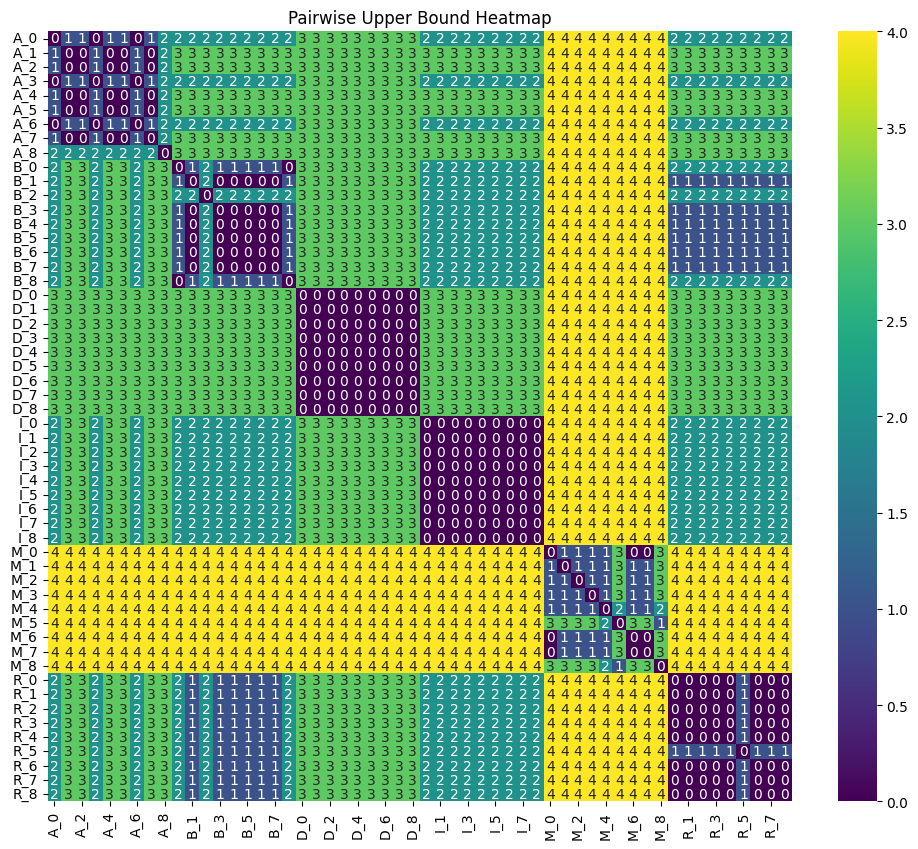

In [97]:

plt.figure(figsize=(12, 10))
sns.heatmap(table.astype(int), cmap="viridis", annot=True)
plt.title("Pairwise Upper Bound Heatmap")
plt.show()


## MDS Plot

In [90]:
table = pd.read_csv("pairwise_results_table.csv", index_col=0)


# Labels (these will be used downstream)
mapper_labels = list(table.index)            
mapper_letters = [lbl.split("_")[0] for lbl in mapper_labels]

# Run MDS on the precomputed distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0, normalized_stress=True)
coords = mds.fit_transform(D)
print(f"Normalized stress: {getattr(mds, 'stress_', float('nan')):.4f}")

# Build mds_df with columns other cells expect
mds_df = pd.DataFrame(coords, columns=["Dim1", "Dim2"])
mds_df["Mapper1"] = mapper_labels
mds_df["Letter"] = mapper_letters
mds_df["Category"] = mapper_letters

# Jitter for plotting
jitter = 0.1
np.random.seed(42)
mds_df["Dim1_j"] = mds_df["Dim1"] + np.random.uniform(-jitter, jitter, size=len(mds_df))
mds_df["Dim2_j"] = mds_df["Dim2"] + np.random.uniform(-jitter, jitter, size=len(mds_df))


Normalized stress: 0.2070


/mnt/home/ghoshis3/.conda/envs/interleavingenv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


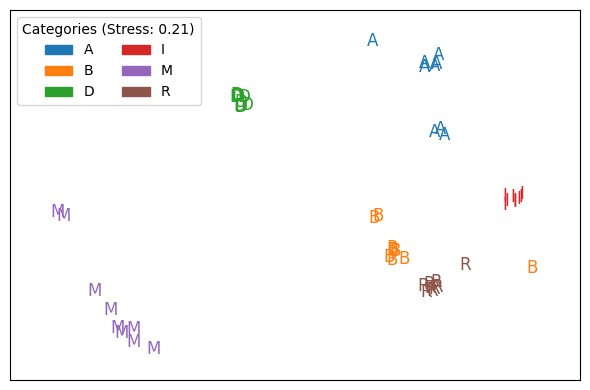

In [91]:
# --- Prepare colors ---
palette = sns.color_palette("tab10", n_colors=6).as_hex() + [
    "#E765CDE0",  # Pink
    "#56B4E9",  # Sky blue
    "#009E73",  # Bluish green
    "#F0E442",  # Yellow    
    "#0072B2",  # Blue
    "#F04F0F",  # Vermillion
]

mapper_letters = [name.split("_")[0] for name in mds_df["Mapper1"]]
color_map = {letter: palette[i] for i, letter in enumerate(sorted(set(mapper_letters)))}

# --- Plot ---
plt.figure(figsize=(6, 4))

# Plot letters as symbols
for i, row in mds_df.iterrows():
    plt.text(row["Dim1_j"], row["Dim2_j"], row["Letter"], fontsize=12,
             ha="center", va="center", color=color_map[row["Letter"]])

# Set axis limits with padding
x_min, x_max = mds_df["Dim1_j"].min(), mds_df["Dim1_j"].max()
y_min, y_max = mds_df["Dim2_j"].min(), mds_df["Dim2_j"].max()
plt.xlim(x_min - 0.1*(x_max-x_min), x_max + 0.1*(x_max-x_min))
plt.ylim(y_min - 0.1*(y_max-y_min), y_max + 0.1*(y_max-y_min))

# Remove axis numbers
plt.xticks([])
plt.yticks([])

# Add legend inside figure
patches = [mpatches.Patch(color=color_map[l], label=l) for l in sorted(color_map)]
plt.legend(handles=patches, title=f"Categories (Stress: {mds.stress_:.2f})", loc="upper left", ncol=2)

# plt.title("MDS Visualization of Mapper Distances")
plt.grid(False)
# sns.despine()
plt.tight_layout()
plt.savefig("mds_mapper_distances.png", dpi=300)
plt.show()


## KNN with loo-cv validation

In [92]:
distdf = pd.read_csv("pairwise_results_table.csv", index_col=0)

print(distdf.index)
dist_matrix = distdf.values
dist_matrix.shape


Index(['A_0', 'A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'B_0',
       'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'D_0', 'D_1',
       'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'I_0', 'I_1', 'I_2',
       'I_3', 'I_4', 'I_5', 'I_6', 'I_7', 'I_8', 'M_0', 'M_1', 'M_2', 'M_3',
       'M_4', 'M_5', 'M_6', 'M_7', 'M_8', 'R_0', 'R_1', 'R_2', 'R_3', 'R_4',
       'R_5', 'R_6', 'R_7', 'R_8'],
      dtype='object')


(54, 54)

## LOO-CV accuracy for k candidates, to tune k


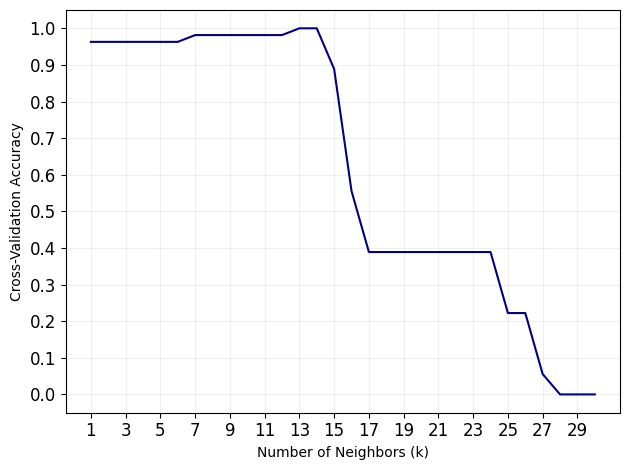

In [93]:
loo = LeaveOneOut()
k_values = range(1, 31)
mean_accuracies = []

for k in k_values:
    preds = []
    for train_idx, test_idx in loo.split(dist_matrix):

        # distance among training samples
        D_train = dist_matrix[np.ix_(train_idx, train_idx)]

        # distance from test sample(s) to training samples
        D_test = dist_matrix[np.ix_(test_idx, train_idx)]

        knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
        knn.fit(D_train, np.array(categories)[train_idx])
        preds.extend(knn.predict(D_test))

    mean_accuracies.append(accuracy_score(categories, preds))

plt.xticks(fontsize=12)

plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)

# Plot accuracy for each k
plt.plot(k_values, mean_accuracies, color="navy")
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
# plt.title('KNN Cross-Validation Accuracy vs. k')
plt.xticks(k_values[::2])
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('knn_accuracy_vs_k.png', dpi=300)
plt.show()


## LOOCV accuracy and confusion matrix for


Categories: ['A_' 'B_' 'D_' 'I_' 'M_' 'R_']
LOO-CV Classification Accuracy: 98.15%


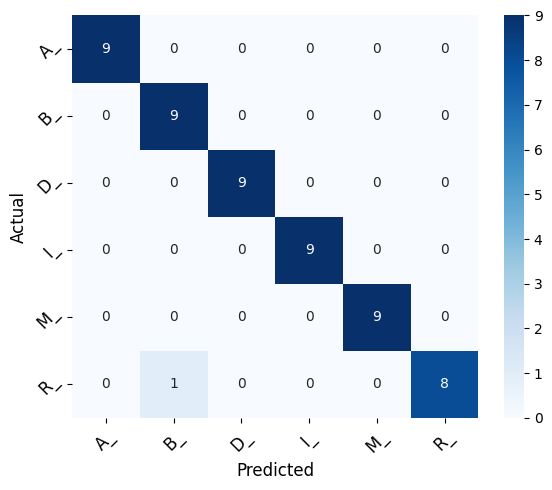

In [101]:
dist_df = pd.read_csv('pairwise_results_table.csv', index_col=0)

labels = dist_df.index
dist_matrix = dist_df.values  # Convert DataFrame to NumPy array


# Extract category names by removing numbers
categories = np.array([label.rstrip("0123456789") for label in labels])

# Print unique categories
print("Categories:", np.unique(categories))

#  Run KNN with Leave-One-Out Cross-Validation (LOO-CV)
loo = LeaveOneOut()
n_neighbors = 9  # Adjust as needed

y_true, y_pred = [], []

for train_index, test_index in loo.split(dist_matrix):
    # training dist matrix (symmetric)
    train_dist = dist_matrix[np.ix_(train_index, train_index)]
    # test dist matrix
    test_dist = dist_matrix[np.ix_(test_index, train_index)].reshape(1, -1) # reshape for single sample

    # test_dist = dist_matrix[np.ix_(test_index, train_index)]

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric="precomputed")
    knn.fit(train_dist, categories[train_index])  # Train on category labels

    pred = knn.predict(test_dist)
    
    y_true.append(categories[test_index][0])
    y_pred.append(pred[0])

# Compute Classification Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"LOO-CV Classification Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred, labels=np.unique(categories))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(categories), yticklabels=np.unique(categories))
plt.xlabel("Predicted", fontsize=12)    
plt.ylabel("Actual", fontsize=12)
# plt.title("Confusion Matrix")
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.tight_layout()
plt.show()


## Nearest-neighbor agreement and permutation test


In [105]:
D = dist_matrix
y = categories
D_copy = D.astype(float).copy()
np.fill_diagonal(D_copy, np.inf)
nn_idx = np.argmin(D_copy, axis=1)
nn_agreement = (y == y[nn_idx]).mean()
print("Nearest-neighbor agreement:", nn_agreement)

# LOOCV k=9
loo = LeaveOneOut()
k = 9
knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
scores = cross_val_score(knn, D, y, cv=loo, scoring='accuracy')
orig = scores.mean()
print(f"LOOCV accuracy (k={k}):", orig)

#permutation test for LOOCV k=9 significance
import random
n_perm = 200
orig = scores[1]
perm_scores = []
for _ in range(n_perm):
    y_perm = np.random.permutation(y)
    perm_scores.append(cross_val_score(KNeighborsClassifier(n_neighbors=1, metric='precomputed'),
                                       D, y_perm, cv=loo).mean())
p_val = (np.sum(np.array(perm_scores) >= orig) + 1) / (n_perm + 1)
print("Permutation p-value:", p_val)


Nearest-neighbor agreement: 0.9629629629629629
LOOCV accuracy (k=9): 0.9814814814814815
Permutation p-value: 0.004975124378109453
